In [ ]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path
from glob import glob
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [ ]:
!apt install rclone -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  rclone
0 upgraded, 1 newly installed, 0 to remove and 49 not upgraded.
Need to get 11.7 MB of archives.
After this operation, 42.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 rclone amd64 1.53.3-4ubuntu1.22.04.3 [11.7 MB]
Fetched 11.7 MB in 3s (4,417 kB/s)
Selecting previously unselected package rclone.
(Reading database ... 123630 files and directories currently installed.)
Preparing to unpack .../rclone_1.53.3-4ubuntu1.22.04.3_amd64.deb ...
Unpacking rclone (1.53.3-4ubuntu1.22.04.3) ...
Setting up rclone (1.53.3-4ubuntu1.22.04.3) ...
Processing triggers for man-db (2.10.2-1) ...


In [ ]:
!rclone config

2024/11/26 18:12:20 NOTICE: Config file "/root/.config/rclone/rclone.conf" not found - using defaults
No remotes found - make a new one
n) New remote
s) Set configuration password
q) Quit config
n/s/q> n
name> dropbox
Type of storage to configure.
Enter a string value. Press Enter for the default ("").
Choose a number from below, or type in your own value
 1 / 1Fichier
   \ "fichier"
 2 / Alias for an existing remote
   \ "alias"
 3 / Amazon Drive
   \ "amazon cloud drive"
 4 / Amazon S3 Compliant Storage Provider (AWS, Alibaba, Ceph, Digital Ocean, Dreamhost, IBM COS, Minio, Tencent COS, etc)
   \ "s3"
 5 / Backblaze B2
   \ "b2"
 6 / Box
   \ "box"
 7 / Cache a remote
   \ "cache"
 8 / Citrix Sharefile
   \ "sharefile"
 9 / Dropbox
   \ "dropbox"
10 / Encrypt/Decrypt a remote
   \ "crypt"
11 / FTP Connection
   \ "ftp"
12 / Google Cloud Storage (this is not Google Drive)
   \ "google cloud storage"
13 / Google Drive
   \ "drive"
14 / Google Photos
   \ "google photos"
15 / Hubic
   \

In [ ]:
!mkdir -p /content/dropbox

In [ ]:
!rclone mount dropbox:/ /content/dropbox --daemon

In [ ]:
!ls /content/dropbox/Lu\ Yifan

filenames_mapped_ages.csv  MRI_survival  Videos_head_all


In [ ]:
class FrameGenerator:
    def __init__(self, file_paths, n_frames, training=False):
        self.file_paths = file_paths
        self.n_frames = n_frames
        self.training = training
        self.bg_subtractor = cv2.createBackgroundSubtractorMOG2(detectShadows=False)  # Background subtractor

    def __call__(self):
        for video_path, label in self.file_paths:
            frames = self._extract_frames(video_path)
            yield frames, label

    def _extract_frames(self, video_path):
        cap = cv2.VideoCapture(str(video_path))
        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        frame_indices = np.linspace(0, total_frames - 1, self.n_frames).astype(int)
        frames = []

        for idx in range(total_frames):
            ret, frame = cap.read()
            if not ret:
                break
            if idx in frame_indices:
                # Apply background subtraction
                fg_mask = self.bg_subtractor.apply(frame)

                # Optionally, use the mask to keep the moving objects
                frame = cv2.bitwise_and(frame, frame, mask=fg_mask)

                # Resize and normalize
                frame = cv2.resize(frame, (128, 128))
                frame = frame / 255.0  # Normalize to [0, 1]
                frames.append(frame)
        cap.release()

        # Pad with black frames if fewer than n_frames
        while len(frames) < self.n_frames:
            frames.append(np.zeros((128, 128, 3)))
        return np.array(frames)

In [ ]:
# Paths to .avi and .csv files
video_dir = Path("/content/dropbox/Lu\ Yifan/Videos_head_all")
video_paths = list(video_dir.glob("*.avi"))
data = pd.read_csv('/content/dropbox/Lu Yifan/filenames_mapped_ages.csv')

# Define lifestage bins
bins = [0, 5, 10, 15, 20]  # Percentage ranges
labels = [3, 2, 1, 0]  # Corresponding lifestages (reverse for decreasing lifespan)
data['lifestage'] = pd.cut(data['daysRemain'], bins=bins, labels=labels, include_lowest=True)
data = data.dropna(subset=['lifestage'])

# Split into train, validation, and test sets
data['filePath'] = data['filename'].apply(lambda x: video_dir / x)
train = data[data['testing']==0]  # 80% train, 20% temp
test = data[data['testing']==1]
grouped = test.groupby(['wormID', 'age'])
val_groups, test_groups = train_test_split(list(grouped.groups.keys()), test_size=0.5, random_state=42)
val = test[test[['wormID', 'age']].apply(tuple, axis=1).isin(val_groups)]
test = test[test[['wormID', 'age']].apply(tuple, axis=1).isin(test_groups)]

# Define subset_paths
subset_paths = {
    'train': list(zip(train['filePath'], train['lifestage'])),
    'val': list(zip(val['filePath'], val['lifestage'])),
    'test': list(zip(test['filePath'], test['lifestage']))
}

In [ ]:
HEIGHT = 224
WIDTH = 224
NUM_FRAMES = 16
NUM_CLASSES = 4
BATCH_SIZE = 4

In [ ]:
# Define the output signature for the dataset
output_signature = (
    tf.TensorSpec(shape=(NUM_FRAMES, None, None, 3), dtype=tf.float32),  # Video frames
    tf.TensorSpec(shape=(), dtype=tf.int64)  # Label
)

# Create datasets for train, validation, and test splits
train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['train'], NUM_FRAMES, training=True),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()

val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['val'], NUM_FRAMES),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths['test'], NUM_FRAMES),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# (2+1)D Convolution Layer
class Conv2Plus1D(layers.Layer):
    def __init__(self, filters, kernel_size, padding):
        """
        A sequence of convolutional layers applying spatial convolutions followed by temporal convolutions.
        """
        super(Conv2Plus1D, self).__init__()
        self.seq = tf.keras.Sequential([
            # Spatial decomposition
            layers.Conv3D(filters=filters, kernel_size=(1, kernel_size[1], kernel_size[2]), padding=padding),
            # Temporal decomposition
            layers.Conv3D(filters=filters, kernel_size=(kernel_size[0], 1, 1), padding=padding),
        ])

    def call(self, x):
        return self.seq(x)

In [ ]:
# Residual Block Main Branch
class ResidualMain(layers.Layer):
    def __init__(self, filters, kernel_size):
        """
        Residual block's main branch with Conv2Plus1D, LayerNormalization, and ReLU activations.
        """
        super(ResidualMain, self).__init__()
        self.seq = tf.keras.Sequential([
            Conv2Plus1D(filters=filters, kernel_size=kernel_size, padding='same'),
            layers.LayerNormalization(),
            layers.ReLU(),
            Conv2Plus1D(filters=filters, kernel_size=kernel_size, padding='same'),
            layers.LayerNormalization(),
        ])

    def call(self, x):
        return self.seq(x)

In [ ]:
# Projection Layer for Matching Dimensions
class Project(layers.Layer):
    def __init__(self, units):
        """
        Projects input to match the dimensions of the residual output.
        """
        super(Project, self).__init__()
        self.seq = tf.keras.Sequential([
            layers.Dense(units),
            layers.LayerNormalization(),
        ])

    def call(self, x):
        return self.seq(x)

In [ ]:
# Add Residual Block with Skip Connection
def add_residual_block(input, filters, kernel_size):
    """
    Adds a residual block to the model. If dimensions mismatch, use the Project layer.
    """
    out = ResidualMain(filters, kernel_size)(input)
    res = input
    if out.shape[-1] != input.shape[-1]:
        res = Project(out.shape[-1])(res)
    return layers.add([res, out])

In [ ]:
# Resize Layer for Dimensionality Reduction
class ResizeVideo(layers.Layer):
    def __init__(self, height, width):
        """
        Resizes video frames to the specified height and width.
        """
        super(ResizeVideo, self).__init__()
        self.resizing_layer = layers.Resizing(height, width)

    def call(self, video):
        return tf.map_fn(self.resizing_layer, video)

In [ ]:
def create_vivit_transformer(features, num_heads, embed_dim, num_layers):
    # Initial Linear Projection
    x = layers.Dense(embed_dim)(features)

    # Transformer Layers
    for _ in range(num_layers):
        # Multi-Head Self-Attention
        attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
        x = layers.LayerNormalization()(x + attn_output)  # Residual connection

        # Feedforward Neural Network
        ffn_output = layers.Dense(embed_dim, activation='relu')(x)
        x = layers.LayerNormalization()(x + ffn_output)  # Residual connection

    return x

In [ ]:
# Build the Model
def create_model(input_shape, num_classes):
    """
    Creates the video processing model with residual connections and resizing.
    """
    input = layers.Input(shape=input_shape)

    # Initial Block
    x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

    # Residual Blocks
    x = add_residual_block(x, 16, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

    x = add_residual_block(x, 32, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

    x = add_residual_block(x, 64, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

    x = add_residual_block(x, 128, (3, 3, 3))

    # Final Layers
    x = layers.GlobalAveragePooling3D()(x)
    x = create_vivit_transformer(x, num_heads=4, embed_dim=128, num_layers=2)
    x = layers.Flatten()(x)
    x = layers.Dropout(0.3)(x)  # 30% dropout
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

    output = layers.Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=input, outputs=output)
    return model

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 16, 224, 224,   │              0 │ -                      │
│                           │ 3)                     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_plus1d              │ (None, 16, 224, 224,   │          3,152 │ input_layer[0][0]      │
│ (Conv2Plus1D)             │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16, 224, 224,   │             64 │ conv2_plus1d[0][0]     │
│ (BatchNormalization)      │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 16, 224, 224,   │              0 │ batch_normalization[0… │
│                           │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video              │ (None, 16, 112, 112,   │              0 │ re_lu[0][0]            │
│ (ResizeVideo)             │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main             │ (None, 16, 112, 112,   │          6,272 │ resize_video[0][0]     │
│ (ResidualMain)            │ 16)                    │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 16, 112, 112,   │              0 │ resize_video[0][0],    │
│                           │ 16)                    │                │ residual_main[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_1            │ (None, 16, 56, 56, 16) │              0 │ add[0][0]              │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ project (Project)         │ (None, 16, 56, 56, 32) │            608 │ resize_video_1[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main_1           │ (None, 16, 56, 56, 32) │         20,224 │ resize_video_1[0][0]   │
│ (ResidualMain)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, 16, 56, 56, 32) │              0 │ project[0][0],         │
│                           │                        │                │ residual_main_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ resize_video_2            │ (None, 16, 28, 28, 32) │              0 │ add_1[0][0]            │
│ (ResizeVideo)             │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ project_1 (Project)       │ (None, 16, 28, 28, 64) │          2,240 │ resize_video_2[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ residual_main_2           │ (None, 16, 28, 28, 64) │         80,384 │ resize_video_2[0][0]   │
│ (ResidualMain)       

 Total params: 459,060 (1.75 MB)

 Trainable params: 459,028 (1.75 MB)

 Non-trainable params: 32 (128.00 B)

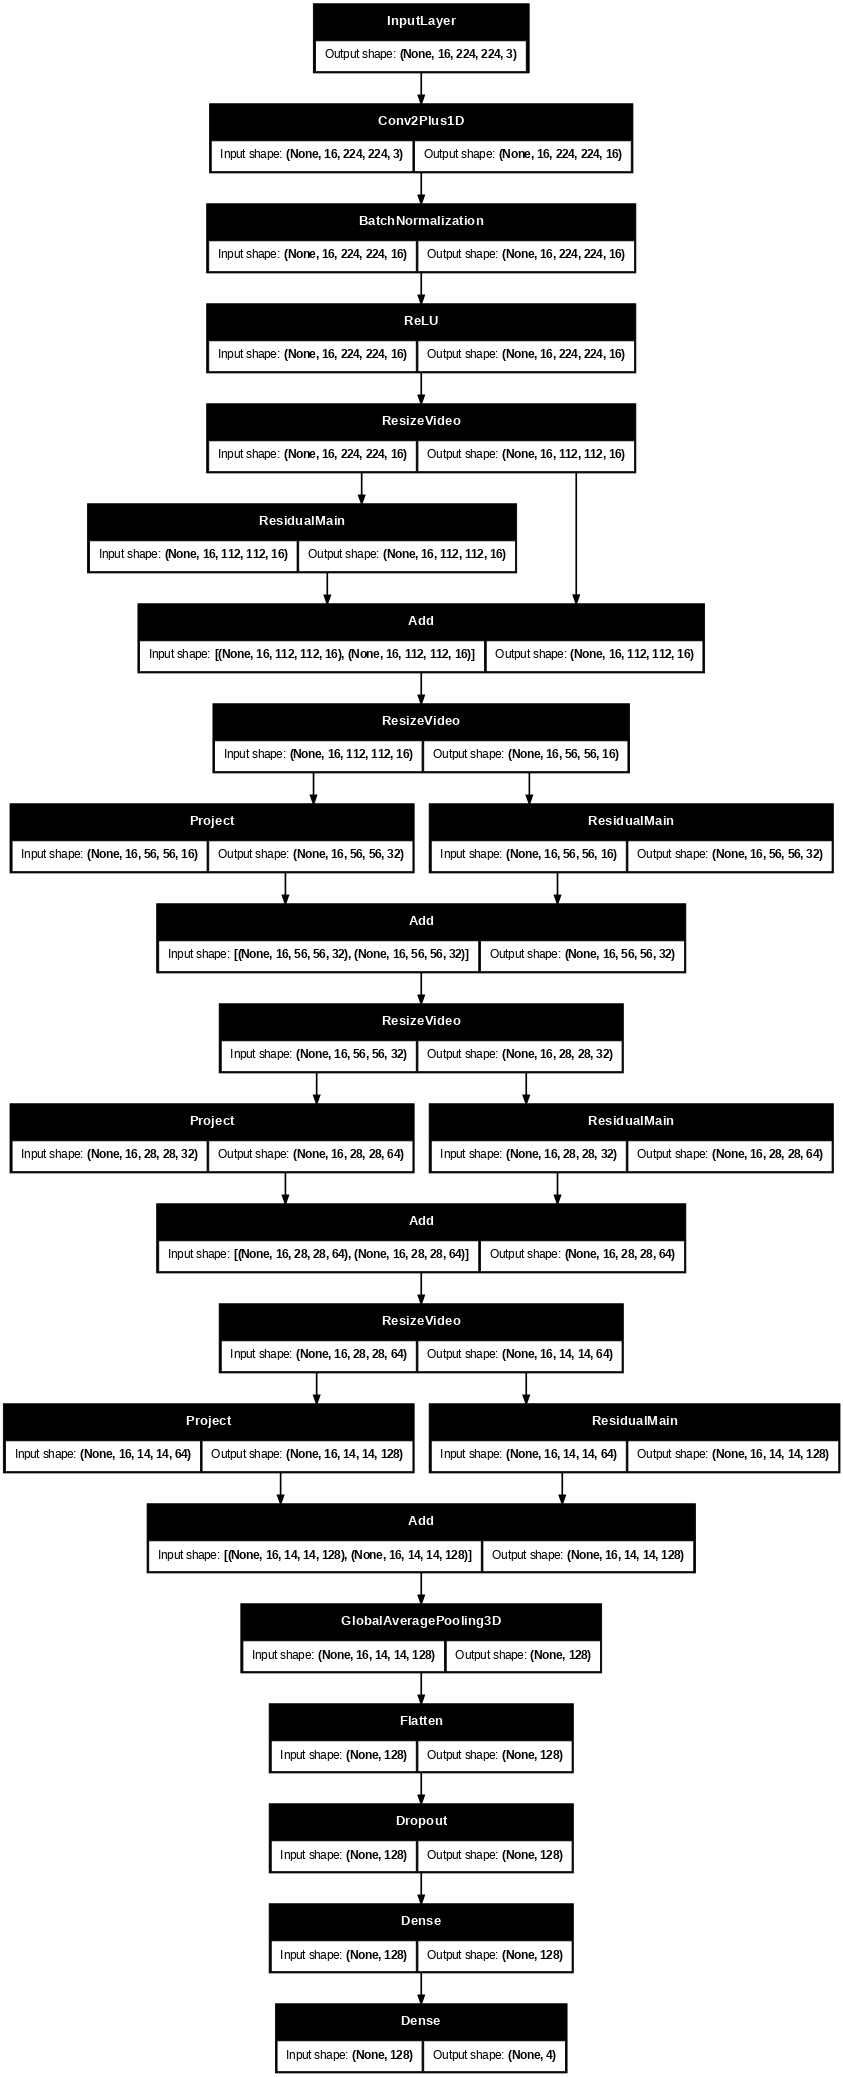

In [ ]:
# Instantiate the Model
model = create_model(input_shape=(NUM_FRAMES, HEIGHT, WIDTH, 3), num_classes=NUM_CLASSES)

# Model Summary
model.summary()

# Plot the Model Architecture
tf.keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [ ]:
# Compute baseline accuracy
most_frequent_class = np.bincount(data['lifestage']).argmax()
baseline_accuracy = np.sum(data['lifestage'] == most_frequent_class) / len(data)

print(f"Baseline Accuracy (most frequent class): {baseline_accuracy:.4f}")

Baseline Accuracy (most frequent class): 0.5260


In [ ]:
# Compile the model
model.compile(
    loss=SparseCategoricalCrossentropy(from_logits=False),
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    steps_per_epoch=105
)

Epoch 1/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 54s 227ms/step - accuracy: 0.4419 - loss: 1.3973 - val_accuracy: 0.5858 - val_loss: 1.3910
Epoch 2/30
  1/105 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.2500 - loss: 1.3957

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


105/105 ━━━━━━━━━━━━━━━━━━━━ 21s 196ms/step - accuracy: 0.3176 - loss: 1.3931 - val_accuracy: 0.5858 - val_loss: 1.3859
Epoch 3/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 23s 222ms/step - accuracy: 0.4733 - loss: 1.3852 - val_accuracy: 0.5858 - val_loss: 1.3793
Epoch 4/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 193ms/step - accuracy: 0.6200 - loss: 1.3760 - val_accuracy: 0.5858 - val_loss: 1.3721
Epoch 5/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 214ms/step - accuracy: 0.5314 - loss: 1.3713 - val_accuracy: 0.5858 - val_loss: 1.3662
Epoch 6/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 9s 83ms/step - accuracy: 0.6486 - loss: 1.3606 - val_accuracy: 0.5858 - val_loss: 1.3639
Epoch 7/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 191ms/step - accuracy: 0.5005 - loss: 1.3684 - val_accuracy: 0.5858 - val_loss: 1.3568
Epoch 8/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 22s 210ms/step - accuracy: 0.3176 - loss: 1.3708 - val_accuracy: 0.5858 - val_loss: 1.3533
Epoch 9/30
105/105 ━━━━━━━━━━━━━━━━━━━━ 20s 188ms/step - accuracy: 0.4733 - loss: 1.3558 - val_a

### Regression

In [ ]:
# Define subset_paths
subset_paths_reg = {
    'train': list(zip(train['filePath'], train['daysRemain'])),
    'val': list(zip(val['filePath'], val['daysRemain'])),
    'test': list(zip(test['filePath'], test['daysRemain']))
}

# Create datasets for train, validation, and test splits
train_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths_reg['train'], NUM_FRAMES, training=True),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE).cache()

val_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths_reg['val'], NUM_FRAMES),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_generator(
    FrameGenerator(subset_paths_reg['test'], NUM_FRAMES),
    output_signature=output_signature
).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
y_true = data['daysRemain'].values

# Baseline prediction: use the mean of the target variable
baseline_prediction = np.mean(y_true)

# Compute Baseline MAE
baseline_mae = np.mean(np.abs(y_true - baseline_prediction))

print(f"Baseline MAE (mean prediction): {baseline_mae:.4f}")

Baseline MAE (mean prediction): 3.3549


In [ ]:
def create_reg_model(input_shape):
    """
    Creates the video processing model for regression.
    """
    input = layers.Input(shape=input_shape)

    # Initial Block
    x = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = ResizeVideo(HEIGHT // 2, WIDTH // 2)(x)

    # Residual Blocks
    x = add_residual_block(x, 16, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 4, WIDTH // 4)(x)

    x = add_residual_block(x, 32, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 8, WIDTH // 8)(x)

    x = add_residual_block(x, 64, (3, 3, 3))
    x = ResizeVideo(HEIGHT // 16, WIDTH // 16)(x)

    x = add_residual_block(x, 128, (3, 3, 3))

    # Final Layers
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Flatten()(x)

    # Add Dropout and Dense Layers
    x = layers.Dropout(0.3)(x)
    x = layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)

    # Output Layer for Regression (1 neuron, no activation)
    output = layers.Dense(1)(x)

    # Create and return the model
    model = Model(inputs=input, outputs=output)
    return model

# Instantiate the model
model = create_reg_model(input_shape=(NUM_FRAMES, HEIGHT, WIDTH, 3))

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['r2']
)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=30,
    batch_size=8
)

Epoch 1/30
    560/Unknown 115s 163ms/step - loss: 55.4190 - mae: 6.0542

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


560/560 ━━━━━━━━━━━━━━━━━━━━ 121s 174ms/step - loss: 55.4116 - mae: 6.0540 - val_loss: 49.5893 - val_mae: 5.7076
Epoch 2/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 124s 165ms/step - loss: 54.7994 - mae: 6.0085 - val_loss: 49.0098 - val_mae: 5.6606
Epoch 3/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 142s 165ms/step - loss: 54.1903 - mae: 5.9626 - val_loss: 48.4377 - val_mae: 5.6136
Epoch 4/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 93s 166ms/step - loss: 53.5885 - mae: 5.9167 - val_loss: 47.8727 - val_mae: 5.5668
Epoch 5/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 141s 165ms/step - loss: 52.9936 - mae: 5.8709 - val_loss: 47.3141 - val_mae: 5.5200
Epoch 6/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 143s 168ms/step - loss: 52.4052 - mae: 5.8252 - val_loss: 46.7619 - val_mae: 5.4734
Epoch 7/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 94s 167ms/step - loss: 51.8231 - mae: 5.7796 - val_loss: 46.2159 - val_mae: 5.4268
Epoch 8/30
560/560 ━━━━━━━━━━━━━━━━━━━━ 142s 167ms/step - loss: 51.2473 - mae: 5.7341 - val_loss: 45.6761 - val_mae: 5.3803
Epoch 9/30
560/560 ━━